In [1]:
#This is based on:
# https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8759878
#codebase is from:
# https://www.kaggle.com/code/christianlillelund/classify-mnist-audio-using-spectrograms-keras-cnn/notebook

In [2]:
!pip install py-ecg-detectors

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#change dependencies to avoid moduls not available in the tensorflow kernel on jupyter hub
import csv
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
import os
import sys
from ecgdetectors import Detectors
from scipy import signal as siglib
import icentiaDataProcessor
from tensorflow.keras import layers
from scipy import signal as siglib
from scipy.fft import fftshift
import icentiaDataProcessor
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


(9000, 1)
(9000,)


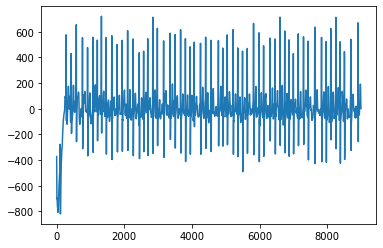

In [2]:
#load a testsample
data = sio.loadmat('/shared_data/training/'+'train_ecg_00097'+'.mat')
signal = data['val'].T
print(signal.shape)
signal = np.ravel(signal)
print(signal.shape)
plt.plot(signal) 
plt.show()

In [3]:
fs = 300

The start and end index are:  900 8100
The new length of the signal is:  7200


<function matplotlib.pyplot.show(close=None, block=None)>

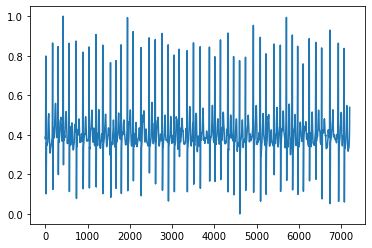

In [4]:
#cutoff the first and last 3 seconds of the signal
startindex = fs * 3 #seconds
endindex = signal.size - startindex
print("The start and end index are: ",startindex, endindex)
cutsignal = signal[startindex:endindex]
print("The new length of the signal is: ",cutsignal.size)

#normalise signalvalues
normalisesignal = (cutsignal - np.min(cutsignal)) / (np.max(cutsignal) - np.min(cutsignal))

#plot the cut and normalised signal
plt.plot(normalisesignal)
plt.show

160


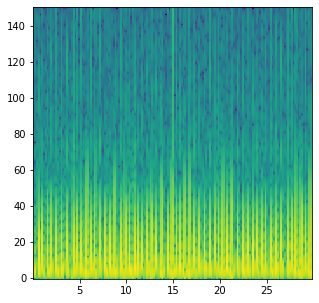

In [5]:
from scipy import signal as siglib
from scipy.fft import fftshift
import icentiaDataProcessor
np.set_printoptions(threshold=sys.maxsize)
nperseg_value = 64
plt.figure(figsize=(5,5))
normalisesignal=icentiaDataProcessor.preprocessData(normalisesignal,9000,300)
f,t, Sxx = siglib.spectrogram(normalisesignal, fs=300, nfft=512, nperseg=nperseg_value)

plt.pcolor(t, f, 10*np.log10(Sxx))
Sxx.shape
dim_len = Sxx.shape[1]
print(dim_len)

In [6]:
batch_size_const = 1024

In [7]:
#Data Generator for icentia11k dataset

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import icentiaDataProcessor

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=batch_size_const, dim=(257,dim_len), n_channels=1,
                 n_classes=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(len(self.list_IDs))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        patient = self.list_IDs[index][0]
        batch   = self.list_IDs[index][1]

        # Generate data
        X, y = self.__data_generation(patient, batch)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, patient, batch):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes))

        # Generate data
        X, y = icentiaDataProcessor.getData_spectro(patient, batch, self.batch_size)
        X = np.asarray(X)
        y = np.asarray(y)
        return X, y

In [8]:
from keras.models import Sequential
#from my_classes import DataGenerator

# Parameters
params = {'dim': (257,dim_len),
          'batch_size': batch_size_const,
          'n_classes': 4,
          'n_channels': 1,
          'shuffle': True}

# Generators
training_generator = DataGenerator(np.load('patientdata_evaluated/list_for_training_generator.npy'), **params)
validation_generator = DataGenerator(np.load('patientdata_evaluated/list_for_validation_generator.npy'), **params)

In [11]:
a = training_generator.__getitem__(2)

In [12]:
#print(a[0][0][0])

In [18]:
from tensorflow.keras import layers

def Jmodel(size):
    inputs = keras.Input(shape=size)

    x = layers.Conv2D(8, 4, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(13, 2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(13, 2, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(4, activation='softmax')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [15]:
model = Jmodel((257,dim_len,1))
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 257, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 257, 160, 8)       136       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 80, 8)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 80, 13)       429       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 40, 13)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 40, 13)        689   

2022-07-04 22:51:47.734668: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-04 22:51:47.734707: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kismed-cs-epilepsy
2022-07-04 22:51:47.734716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kismed-cs-epilepsy
2022-07-04 22:51:47.734836: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-07-04 22:51:47.734857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-07-04 22:51:47.734863: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-07-04 22:51:47.735073: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the followi

In [ ]:
model=keras.models.load_model('model.h5')

checkpoint_filepath = "saved-model-{epoch:02d}_training2.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_freq='epoch',
    save_best_only=False)

with tf.device('/CPU:0'):
    history = model.fit(training_generator, validation_data=validation_generator, epochs=5, callbacks=[model_checkpoint_callback])

2022-07-05 06:23:30.338432: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-07-05 06:23:30.338470: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kismed-cs-epilepsy
2022-07-05 06:23:30.338477: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kismed-cs-epilepsy
2022-07-05 06:23:30.338654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-07-05 06:23:30.338674: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-07-05 06:23:30.338679: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-07-05 06:23:30.338932: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the followi

Epoch 1/5
   5/2436 [..............................] - ETA: 4:29:14 - loss: 0.6887 - accuracy: 0.7512

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05963_s23
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05963_s25
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05963_s26
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p05963_s41
  warnings.warn("Undefined rhythm annotation should not "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p05963_s44
  warnings.warn("Undefined rhythm annotation should not "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarn

  21/2436 [..............................] - ETA: 4:06:12 - loss: 0.6764 - accuracy: 0.7021

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p09337_s40
  warnings.warn("Undefined rhythm annotation should not "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09337_s42
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09337_s43
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09337_s45
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09337_s46
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


  35/2436 [..............................] - ETA: 4:05:35 - loss: 0.6227 - accuracy: 0.7388

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s05. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s07. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s08. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s09. Spliting rhythm zones surrounding extra 

  36/2436 [..............................] - ETA: 4:04:47 - loss: 0.6225 - accuracy: 0.7440

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s24. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s25. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s26. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01420_s28. Spliting rhythm zones surrounding extra 

  62/2436 [..............................] - ETA: 3:57:39 - loss: 0.6648 - accuracy: 0.7442

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p05297_s41. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


  74/2436 [..............................] - ETA: 3:55:45 - loss: 0.6347 - accuracy: 0.7440

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p06547_s27
  warnings.warn("Undefined rhythm annotation should not "


 103/2436 [>.............................] - ETA: 3:52:52 - loss: 0.6812 - accuracy: 0.7363

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p00591_s46
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p00591_s47
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


 115/2436 [>.............................] - ETA: 3:50:40 - loss: 0.6705 - accuracy: 0.7420

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p04081_s46
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


 120/2436 [>.............................] - ETA: 3:50:17 - loss: 0.6614 - accuracy: 0.7475

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s26. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s27. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s28. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s29. Spliting rhythm zones surrounding extra 

 121/2436 [>.............................] - ETA: 3:50:14 - loss: 0.6595 - accuracy: 0.7480

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s32. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s33. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s34. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06726_s35. Spliting rhythm zones surrounding extra 

 169/2436 [=>............................] - ETA: 3:44:43 - loss: 0.6642 - accuracy: 0.7383

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p07992_s00. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


 170/2436 [=>............................] - ETA: 3:44:38 - loss: 0.6685 - accuracy: 0.7340

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p07992_s16. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


 301/2436 [==>...........................] - ETA: 3:30:24 - loss: 0.6772 - accuracy: 0.7151

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p02512_s49
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


 302/2436 [==>...........................] - ETA: 3:30:18 - loss: 0.6762 - accuracy: 0.7152

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p09533_s28
  warnings.warn("Undefined rhythm annotation should not "


 342/2436 [===>..........................] - ETA: 3:26:42 - loss: 0.6648 - accuracy: 0.7225

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p03871_s47
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


 407/2436 [====>.........................] - ETA: 3:20:15 - loss: 0.6916 - accuracy: 0.7179

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p01989_s28
  warnings.warn("Undefined rhythm annotation should not "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p01989_s30
  warnings.warn("Undefined rhythm annotation should not "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p01989_s37
  warnings.warn("Undefined rhythm annotation should not "


 604/2436 [======>.......................] - ETA: 2:59:53 - loss: 0.6893 - accuracy: 0.7206

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05357_s33
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05357_s34
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05357_s35
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05357_s36
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05357_s48
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p05357_s49
  warnings.warn("Empty annotatio

 707/2436 [=======>......................] - ETA: 2:49:48 - loss: 0.6879 - accuracy: 0.7225

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09486_s35
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09486_s36
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09486_s49
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


 725/2436 [=======>......................] - ETA: 2:47:59 - loss: 0.6844 - accuracy: 0.7241

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p06381_s46
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


 771/2436 [========>.....................] - ETA: 2:41:42 - loss: 0.6864 - accuracy: 0.7230

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04902_s31. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


 796/2436 [========>.....................] - ETA: 2:37:57 - loss: 0.6853 - accuracy: 0.7225

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p09517_s00. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


 827/2436 [=========>....................] - ETA: 2:33:28 - loss: 0.6842 - accuracy: 0.7231

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04641_s21. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04641_s22. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04641_s33. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04641_s34. Spliting rhythm zones surrounding extra 

 836/2436 [=========>....................] - ETA: 2:32:18 - loss: 0.6853 - accuracy: 0.7217

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p09257_s48
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


1029/2436 [===========>..................] - ETA: 2:07:45 - loss: 0.6984 - accuracy: 0.7134

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p07988_s01. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


1060/2436 [============>.................] - ETA: 2:04:07 - loss: 0.7000 - accuracy: 0.7119

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p03468_s29
  warnings.warn("Undefined rhythm annotation should not "


1133/2436 [============>.................] - ETA: 1:55:57 - loss: 0.7060 - accuracy: 0.7107

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p04240_s49
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


1219/2436 [==============>...............] - ETA: 1:46:50 - loss: 0.7062 - accuracy: 0.7116

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p10949_s20
  warnings.warn("Undefined rhythm annotation should not "


1357/2436 [===============>..............] - ETA: 1:34:29 - loss: 0.7018 - accuracy: 0.7145

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p01165_s49
  warnings.warn("Undefined rhythm annotation should not "


1483/2436 [=================>............] - ETA: 1:24:16 - loss: 0.6995 - accuracy: 0.7161

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04064_s41. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


1589/2436 [==================>...........] - ETA: 1:15:28 - loss: 0.7008 - accuracy: 0.7151

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04800_s10. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04800_s11. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04800_s13. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p04800_s24. Spliting rhythm zones surrounding extra 

1767/2436 [====================>.........] - ETA: 1:00:16 - loss: 0.7029 - accuracy: 0.7140

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p00148_s06
  warnings.warn("Undefined rhythm annotation should not "


1768/2436 [====================>.........] - ETA: 1:00:11 - loss: 0.7028 - accuracy: 0.7140

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p00148_s44
  warnings.warn("Undefined rhythm annotation should not "


1955/2436 [=======================>......] - ETA: 43:43 - loss: 0.6947 - accuracy: 0.7176

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01749_s41. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p01749_s42. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


2013/2436 [=======================>......] - ETA: 38:33 - loss: 0.6950 - accuracy: 0.7169

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p07048_s47
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(
/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:83: UserWarning: Empty annotations for p07048_s48
  warnings.warn("Empty annotations for p{:05d}_s{:02d}".format(


2047/2436 [========================>.....] - ETA: 35:30 - loss: 0.6930 - accuracy: 0.7186

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:76: UserWarning: Undefined rhythm annotation should not exist in icentia11k for p04721_s44
  warnings.warn("Undefined rhythm annotation should not "


2428/2436 [============================>.] - ETA: 44s - loss: 0.6932 - accuracy: 0.7182

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p06587_s44. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


2436/2436 [==============================] - ETA: 0s - loss: 0.6934 - accuracy: 0.7178

/home/jupyter-wki_team_1/Networks/icentia11k_make_wfdb.py:66: UserWarning: Beat annotations count does not match with rhythm annotations count for p09173_s08. Spliting rhythm zones surrounding extra beats
  warnings.warn("Beat annotations count does not match with "


2436/2436 [==============================] - 15902s 7s/step - loss: 0.6934 - accuracy: 0.7178 - val_loss: 0.6744 - val_accuracy: 0.7346
Epoch 2/5
1145/2436 [=============>................] - ETA: 1:33:13 - loss: 0.6855 - accuracy: 0.7297

In [4]:
mod=keras.models.load_model('model.h5')
mod.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 257, 160, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 257, 160, 8)       136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 80, 8)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 80, 13)       429       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 40, 13)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 40, 13)        689       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 20, 13)        0   

In [ ]:
with tf.device('/CPU:0'):
    mod.evaluate(validation_generator)

In [ ]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Transfer learning & fine-tuning auf die ursprünglichen Daten

In [2]:
def create_bin_label(label):
    index = np.where(label == np.amax(label))
    index = index[0]
    if(index == 0):
        label = np.asarray([1, 0])
    if(index == 1):
        label = np.asarray([0, 1])
    # if(index == 0):
    #     label = np.asarray([1, 0, 0, 0])
    # if(index == 1):
    #     label = np.asarray([0, 1, 0, 0])
    # if(index == 2):
    #     label = np.asarray([0, 0, 1, 0])
    # if(index == 3):
    #     label = np.asarray([0, 0, 0, 1])
    return label

In [25]:
mod=keras.models.load_model('saved-model-03_training4.h5')
mod.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 257, 160, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 257, 160, 8)       136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 80, 8)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 80, 13)       429       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 40, 13)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 40, 13)        689       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 20, 13)        0   

In [26]:
fc1 = mod.layers[-3]
fc2 = mod.layers[-2]
predictions = mod.layers[-1]

# Create the dropout layers
dropout = layers.Dropout(0.4)

# Reconnect the layers
x = fc2(fc1.output)
x = dropout(x)
predictors = layers.Dense(2, activation='softmax')(x)

# Create a new model
mod = keras.Model(mod.input, predictors)

mod.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)
mod.summary()

Model: "functional_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 257, 160, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 257, 160, 8)       136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 80, 8)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 80, 13)       429       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 40, 13)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 40, 13)        689       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 20, 13)       

In [6]:
import wettbewerb

ecg_leads, ecg_labels, fs, ecg_names = wettbewerb.load_references('./ProcessedData/MIT-AtrialFibrillation/')
spectograms = []
labels  = []
for i in range(len(ecg_leads)):
    signal = ecg_leads[i]
    signal = np.ravel(signal)
    signal = icentiaDataProcessor.preprocessData(signal,9000,300,False)
    f, t, Sxx = siglib.spectrogram(signal, fs=300, nfft=512, nperseg=64)
    Sxx = 10*np.log10(Sxx+1e-12)
    Sxx = np.reshape(Sxx, (Sxx.shape[0], Sxx.shape[1], 1))
    
    if ecg_labels[i]=='N': # Zuordnung zu "Normal"
            label=np.asarray([1,0])
            labels.append(label)
            spectograms.append(Sxx)

    if ecg_labels[i]=='A':  # Zuordnung zu "Vorhofflimmern"
            label=np.asarray([0,1])    
            labels.append(label)
            spectograms.append(Sxx)        

#     if ecg_labels[i]=='N': # Zuordnung zu "Normal"
#             label=np.asarray([1,0,0,0])

#     if ecg_labels[i]=='A':  # Zuordnung zu "Vorhofflimmern"
#             label=np.asarray([0,1,0,0])            

#     if ecg_labels[i]=='~':                       
#             label=np.asarray([0,0,1,0])
                
#     if ecg_labels[i]=='O':#Zuordnung zu "Other"                        
#             label=np.asarray([0,0,0,1])
    
    del f, t, Sxx
spectograms = np.asarray(spectograms)
labels = np.asarray(labels)

23958	 Dateien wurden geladen.


In [ ]:
#validation on cnn that is just trained on the icentia data set
predictions = mod.predict(spectograms)
for i in range(len(predictions)):
    predictions[i] = create_bin_label(predictions[i])

metrics.f1_score(labels, predictions, average='micro')

0.4946990566825278

In [33]:
X_train, X_test, y_train, y_test = train_test_split(spectograms, labels, test_size = 0.2, shuffle=True)

NameError: name 'spectograms' is not defined

In [20]:
for i in range(9):
    mod.layers[i].trainable = False

for l in mod.layers:
    print(l.name, l.trainable)

input_3 False
conv2d_4 False
max_pooling2d_2 False
conv2d_5 False
max_pooling2d_3 False
conv2d_6 False
max_pooling2d_4 False
flatten_2 False
dropout_2 False
dense_6 True
dense_7 True


In [27]:
mod.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

In [32]:
checkpoint_filepath = 'model_pretrained_mit.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = mod.fit(X_train, y_train, validation_split=0.2, epochs=4, callbacks=[model_checkpoint_callback])
#history = mod.fit(X_train, y_train,  epochs=10)

NameError: name 'X_train' is not defined

In [24]:
mod.output


<tf.Tensor 'dense_7/Softmax_2:0' shape=(None, 4) dtype=float32>

In [1]:
mod=keras.models.load_model('model_pretrained_mit.h5')

NameError: name 'keras' is not defined

In [18]:
after_first_transfer = mod.evaluate(X_test, y_test)

NameError: name 'X_test' is not defined

In [3]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, TimeMask, Shift, Resample
import numpy as np

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
    TimeMask(min_band_part=0.005, max_band_part=0.01, p=0.3),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.3),
    Shift(min_fraction=-0.5, max_fraction=0.5,rollover=True, p=0.7),
    Resample(min_sample_rate=280, max_sample_rate = 320, p=0.2)

])


# Generate 2 seconds of dummy audio for the sake of example
samples = np.random.uniform(low=-0.2, high=0.2, size=(32000,)).astype(np.float32)

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=samples, sample_rate=16000)

In [4]:
import wettbewerb

ecg_leads, ecg_labels, fs, ecg_names = wettbewerb.load_references('./training')
spectograms_def = []
labels_def  = []
for i in range(len(ecg_leads)):
    signal = ecg_leads[i]
    signal = np.ravel(signal)
    signal = signal.astype(np.float32)
    for j in range(5):
        if(j > 0):
                sig = augment(samples=signal, sample_rate=300)
        else:
                sig = signal
        sig = icentiaDataProcessor.preprocessData(sig,9000,300,False)
        f, t, Sxx = siglib.spectrogram(sig, fs=300, nfft=512, nperseg=64)
        Sxx = 10*np.log10(Sxx+1e-12)
        Sxx = np.reshape(Sxx, (Sxx.shape[0], Sxx.shape[1], 1))
        if ecg_labels[i]=='N': # Zuordnung zu "Normal"
                label=np.asarray([1,0])
                spectograms_def.append(Sxx)
                labels_def.append(label)

        if ecg_labels[i]=='A':  # Zuordnung zu "Vorhofflimmern"
                label=np.asarray([0,1])
                spectograms_def.append(Sxx)
                labels_def.append(label)          
        # if ecg_labels[i]=='N': # Zuordnung zu "Normal"
        #         label=np.asarray([1,0,0,0])

        # if ecg_labels[i]=='A':  # Zuordnung zu "Vorhofflimmern"
        #         label=np.asarray([0,1,0,0])            

        # if ecg_labels[i]=='~':                       
        #         label=np.asarray([0,0,1,0])
                        
        # if ecg_labels[i]=='O':#Zuordnung zu "Other"                        
        #         label=np.asarray([0,0,0,1])
        #if(label[0] == 1 or label[1] == 1):
        del f, t, Sxx
spectograms_def = np.asarray(spectograms_def)
labels_def = np.asarray(labels_def)
print(len(spectograms_def))

6000	 Dateien wurden geladen.
20510


In [86]:
print(spectograms_def[0].shape)

(257, 160, 1)


In [9]:
import random
data = list(zip(spectograms_def, labels_def))
random.shuffle(data)
spectograms_def, labels_def = zip(*data)
indexes = np.asarray([0,0.2,0.4,0.6,0.8,1])
indexes = indexes * len(spectograms_def)
indexes = indexes.astype('int')
indexes[-1] = indexes[-1]-1

spectro_cross = []
label_cross = []
for i in range(len(indexes)-1):
    spectro_cross.append(spectograms_def[indexes[i]:indexes[i+1]])
    label_cross.append(labels_def[indexes[i]:indexes[i+1]])

print(label_cross[0][0])

[1 0]


In [42]:
len(spectro_cross[4])

4101

In [11]:
train = np.asarray([[0,1,2,3],[0,1,2,4],[0,1,3,4],[0,2,3,4],[1,2,3,4]])
print(train[0][0])

0


In [34]:
from sklearn.utils import class_weight
class_weight.compute_sample_weight('balanced',labels_def)

array([ 0.32803688,  0.32803688, 15.49729407, ..., 15.49729407,
        0.32803688,  0.32803688])

In [36]:
    #train = np.asarray([[0,1,2,3],[0,1,2,4],[0,1,3,4],[0,2,3,4],[1,2,3,4]])

train = np.asarray([[0],[1],[3],[2],[4]])
val = np.asarray([[4],[3],[2],[1],[0]])
for i in range(5):
        X_train_def =  []
        y_train_def = []
        X_val_def = []
        y_val_def = []
        # for num in train[i]:
        #     for spec in range(len(spectro_cross[num])):
        #         X_train_def.append(spectro_cross[num][spec])
        #     for lab in range(len(label_cross[num])):
        #         y_train_def.append(label_cross[num][spec].reshape(-1,1))
        # for num in val[i]:
        #     for spec in range(len(spectro_cross[num])):
        #         X_val_def.append(spectro_cross[num][spec])
        #     for lab in range(len(label_cross[num])):
        #         y_val_def.append(label_cross[num][spec].reshape(-1,1))

        X_train_def = np.asarray(spectro_cross[train[i][0]])
        X_val_def = np.asarray(spectro_cross[val[i][0]])
        y_train_def = np.asarray(label_cross[train[i][0]])
        y_val_def = np.asarray(label_cross[val[i][0]])
        history = mod.fit(X_train_def, y_train_def, validation_data=(X_val_def, y_val_def),shuffle=True, epochs=1, sample_weight=class_weight.compute_sample_weight('balanced',y_train_def))#, callbacks=[model_checkpoint_callback], batch_size=512)
        mod.save('crossval'+str(i)+'.h5')


129/129 [==============================] - 36s 279ms/step - loss: 0.6054 - accuracy: 0.4874 - val_loss: 1.6304 - val_accuracy: 0.3742


In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(labels_def),labels_def)
train = np.asarray([[0],[1],[3],[2],[4]])
val = np.asarray([[4],[3],[2],[1],[0]])
for i in range(5):
        X_train_def =  []
        y_train_def = []
        X_val_def = []
        y_val_def = []
        # for num in train[i]:
        #     for spec in range(len(spectro_cross[num])):
        #         X_train_def.append(spectro_cross[num][spec])
        #     for lab in range(len(label_cross[num])):
        #         y_train_def.append(label_cross[num][spec].reshape(-1,1))
        # for num in val[i]:
        #     for spec in range(len(spectro_cross[num])):
        #         X_val_def.append(spectro_cross[num][spec])
        #     for lab in range(len(label_cross[num])):
        #         y_val_def.append(label_cross[num][spec].reshape(-1,1))

        X_train_def = np.asarray(spectro_cross[train[i][0]])
        X_val_def = np.asarray(spectro_cross[val[i][0]])
        y_train_def = np.asarray(label_cross[train[i][0]])
        y_val_def = np.asarray(label_cross[val[i][0]])
        history = mod.fit(X_train_def, y_train_def, validation_data=(X_val_def, y_val_d),shuffle=True, epochs=1)#, callbacks=[model_checkpoint_callback], batch_size=512)
        mod.save('crossval'+str(i)+'.h5')


In [43]:
x = np.asarray(spectro_cross[0])
y = np.asarray(label_cross[0])
history = mod.fit(x, y,shuffle=True, epochs=1)

129/129 [==============================] - 27s 210ms/step - loss: 0.4105 - accuracy: 0.8679


In [ ]:
#validation on cnn that is just trained on the icentia data set
before_second_transfer = mod.evaluate(spectograms_def,labels_def)

188/188 [==============================] - 14s 74ms/step - loss: 4.2445 - accuracy: 0.5587


In [ ]:
X_train_def, X_test_def, y_train_def, y_test_def = train_test_split(spectograms_def, labels_def, test_size = 0)

In [20]:
X_train_def = spectograms_def
y_train_def = labels_def
print(len(X_train_def))

30000


In [1]:
for i in range(9):
    mod.layers[i].trainable = False

for l in mod.layers:
    print(l.name, l.trainable)

NameError: name 'mod' is not defined

In [4]:
checkpoint_filepath = 'model_pretrained_def.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = mod.fit(X_train_def, y_train_def, shuffle=True, validation_split=0.2, epochs=15, callbacks=[model_checkpoint_callback], batch_size=512)

NameError: name 'tf' is not defined

In [90]:
mod=keras.models.load_model('model_pretrained_def.h5')

TypeError: __init__() got an unexpected keyword argument 'axis'

In [16]:
#check for 4 labels
predictions = mod.predict(X_test_def)
for i in range(len(predictions)):
    predictions[i] = create_bin_label(predictions[i])

print(predictions[0])

metrics.f1_score(y_test_def, predictions, average='weighted')

[1. 0. 0. 0.]


0.46233613616387903

In [12]:
X_test_def_2label = []
y_test_def_2label = []
for i in range(len(X_test_def)):
    if(y_test_def[i][0] == 1 or y_test_def[i][1] == 1):
        X_test_def_2label.append(X_test_def[i])
        y_test_def_2label.append(y_test_def[i])

X_test_def_2label = np.asarray(X_test_def_2label)
y_test_def_2label = np.asarray(y_test_def_2label)
print(len(y_test_def_2label))

2040


In [2]:
predictions = mod.predict(X_test_def_2label)
for i in range(len(predictions)):
    predictions[i] = create_bin_label(predictions[i])

pred = []
lab = []
for i in range(len(predictions)):
    pred.append(np.asarray(predictions[i][0]))
    lab.append(np.asarray(y_test_def_2label[i][0]))
metrics.f1_score(lab, pred)

NameError: name 'mod' is not defined

In [8]:
mod.save('spectro.h5')

In [15]:
mod=keras.models.load_model('spectro.h5')
predictions = mod.predict(X_test_def_2label)
for i in range(len(predictions)):
    predictions[i] = create_bin_label(predictions[i])

pred = []
lab = []
for i in range(len(predictions)):
    pred.append(np.asarray(predictions[i][0]))
    lab.append(np.asarray(y_test_def_2label[i][0]))
metrics.f1_score(lab, pred)

0.9276821192052979

In [54]:
pip install audiomentations[extras]

  Using cached audiomentations-0.25.1-py3-none-any.whl (71 kB)
  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
  Using cached pyloudnorm-0.1.0-py3-none-any.whl (9.3 kB)
  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Using cached lameenc-1.4.1-cp38-cp38-win_amd64.whl (158 kB)

  Using cached pyroomacoustics-0.6.0-cp38-cp38-win_amd64.whl (508 kB)
  Using cached numba-0.55.2-cp38-cp38-win_amd64.whl (2.4 MB)
  Using cached SoundFile-0.10.3.post1-py2.py3.cp26.cp27.cp32.cp33.cp34.cp35.cp36.pp27.pp32.pp33-none-win_amd64.whl (689 kB)
  Using cached resampy-0.3.0-py3-none-any.whl (3.1 MB)
  Using cached audioread-2.1.9-py3-none-any.whl
  Using cached llvmlite-0.38.1-cp38-cp38-win_amd64.whl (23.2 MB)
  Using cached Cython-0.29.30-py2.py3-none-any.whl (985 kB)
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)


In [57]:
print(len(augmented_samples))
print(len(samples))


32000
32000


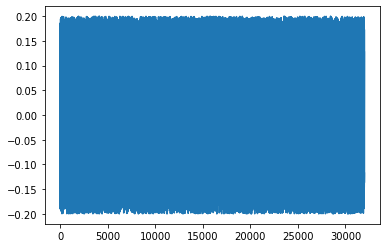

In [58]:
import matplotlib.pyplot as plt
plt.plot(samples)

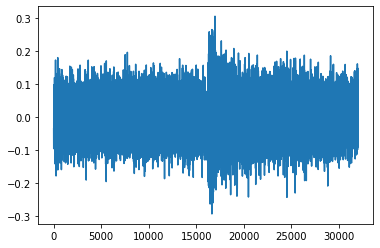

In [59]:
plt.plot(augmented_samples)

In [9]:
import utilz
utilz.predictions_score('./more_data/physio2017_complementary/files/validation/REFERENCE.csv','PREDICTIONS.csv')


(0.8919292090023797, 0.8974358974358975)